In [1]:
# %pip install wandb

In [1]:
import os
import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.autograd as autograd
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import wandb

# Датасет, гиперпараметры, модели

In [2]:
from dataset import ArchNegatives, ArchPositives

from model_nadia_2 import Generator, Discriminator, Encoder

In [3]:
model_name = 'nadia'
version = 'v3'

results_dir = f'results_{model_name}_{version}'

In [7]:
generator_path = f'../train_generator_discriminator/{results_dir}/generator_81.pth'
discriminator_path = f'../train_generator_discriminator/{results_dir}/discriminator_81.pth'
encoder_path = f'../train_izif_encoder/{results_dir}/encoder_199.pth'

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
params = {
    'batch_size': 64,
    'channels': 3,
    'img_size': 64,
    'latent_dim': 100,
    'lr': 0.0002,
    'b1': 0.5,
    'b2': 0.999,
    'n_epochs': 200,
    'n_critic': 5,
    'sample_interval': 400,
}

In [8]:
transform_crop_64 = transforms.Compose([
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [9]:
train_dataset = ArchNegatives(transform=transform_crop_64)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchPositives(transform=transform_crop_64)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [10]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

train: 139945 images, 2187 batches
anomalies: 163 images, 3 batches


In [11]:
generator = Generator(params)
discriminator = Discriminator(params)
encoder = Encoder(params)

In [12]:
# map_location=torch.device('cpu')

generator.load_state_dict(torch.load(generator_path, map_location=torch.device('cpu')))
discriminator.load_state_dict(torch.load(discriminator_path, map_location=torch.device('cpu')))
encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
generator.to(device).eval();
discriminator.to(device).eval();
encoder.to(device).eval();

In [16]:
n_params = 0
for n, p in generator.named_parameters():
    # print(n, p)
    n_params += np.prod(p.shape)

In [17]:
n_params

215499

# Модель сравнения изображений

In [16]:
criterion = nn.MSELoss()
kappa=1.0

# with open("score.csv", "w") as f:
#     f.write("label,img_distance,anomaly_score,z_distance\n")

In [17]:
def test(img):
    
    real_img = img.to(device)
    real_z = encoder(real_img)
    fake_img = generator(real_z)
    fake_z = encoder(fake_img)

    real_feature = discriminator.forward_features(real_img)
    fake_feature = discriminator.forward_features(fake_img)

    img_distance = criterion(fake_img, real_img)
    loss_feature = criterion(fake_feature, real_feature)
    anomaly_score = img_distance + kappa * loss_feature

    z_distance = criterion(fake_z, real_z)
    
    return fake_img, img_distance.item(), anomaly_score.item(), z_distance.item()
    
    # with open("results/score.csv", "a") as f:
    #     f.write(f"{label.item()},{img_distance},"
    #             f"{anomaly_score},{z_distance}\n")
    

# Смотрим, как восстанавливаются картинки

## Train dataset

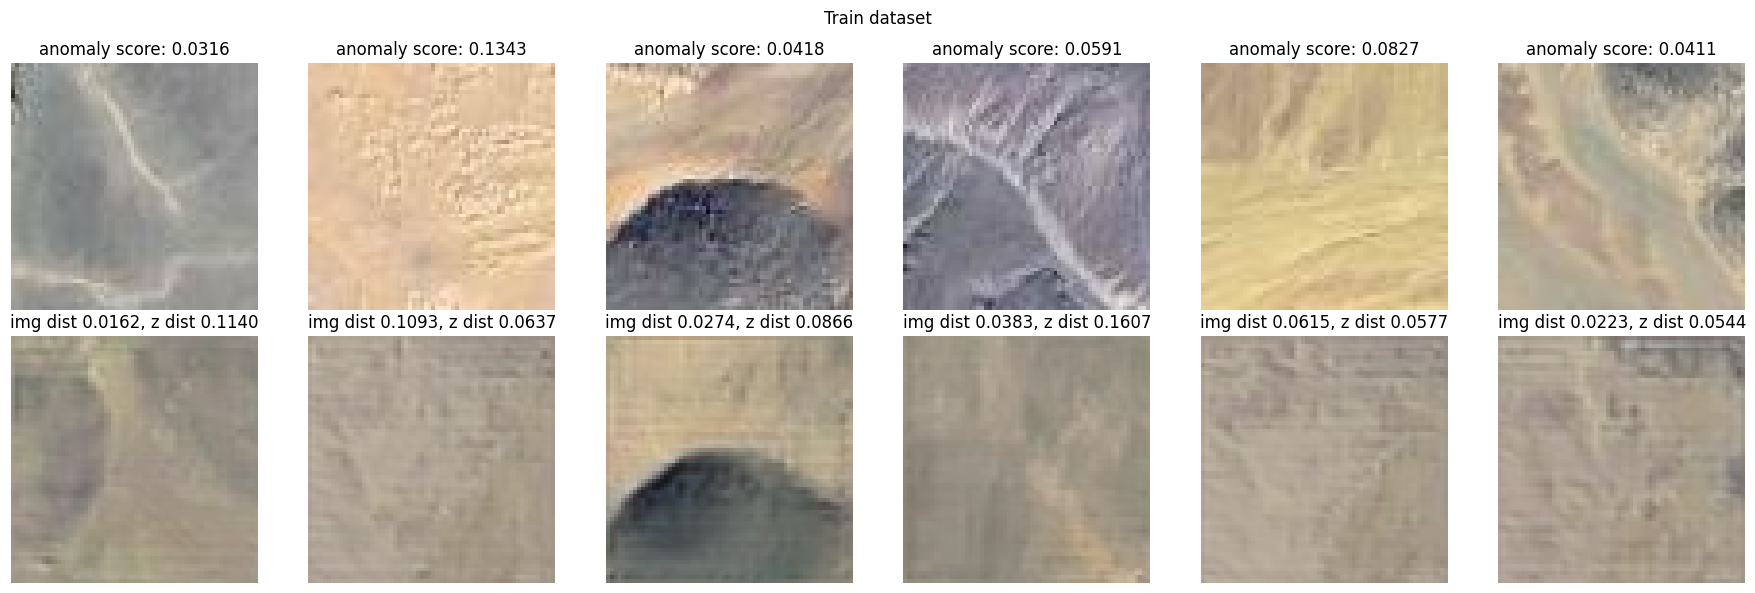

In [18]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[j]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

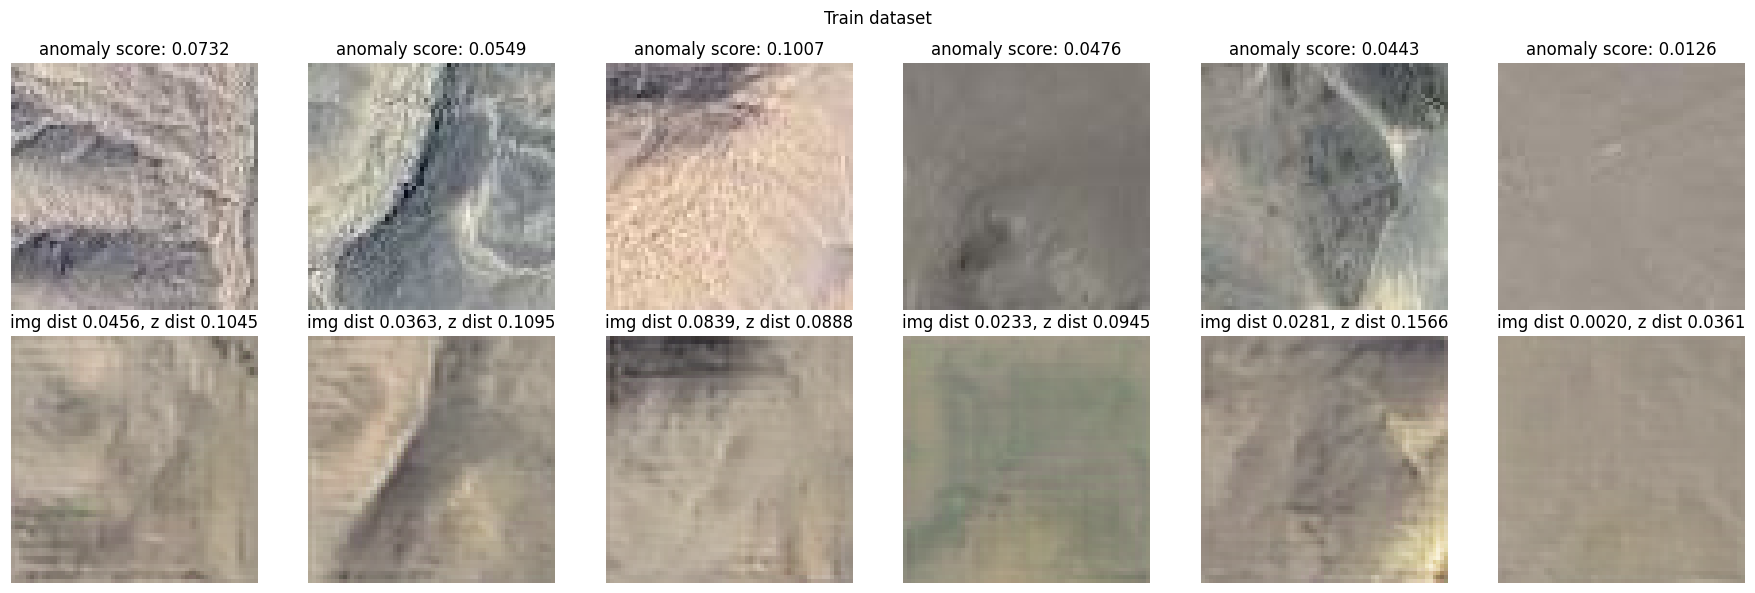

In [19]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[j + 6]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

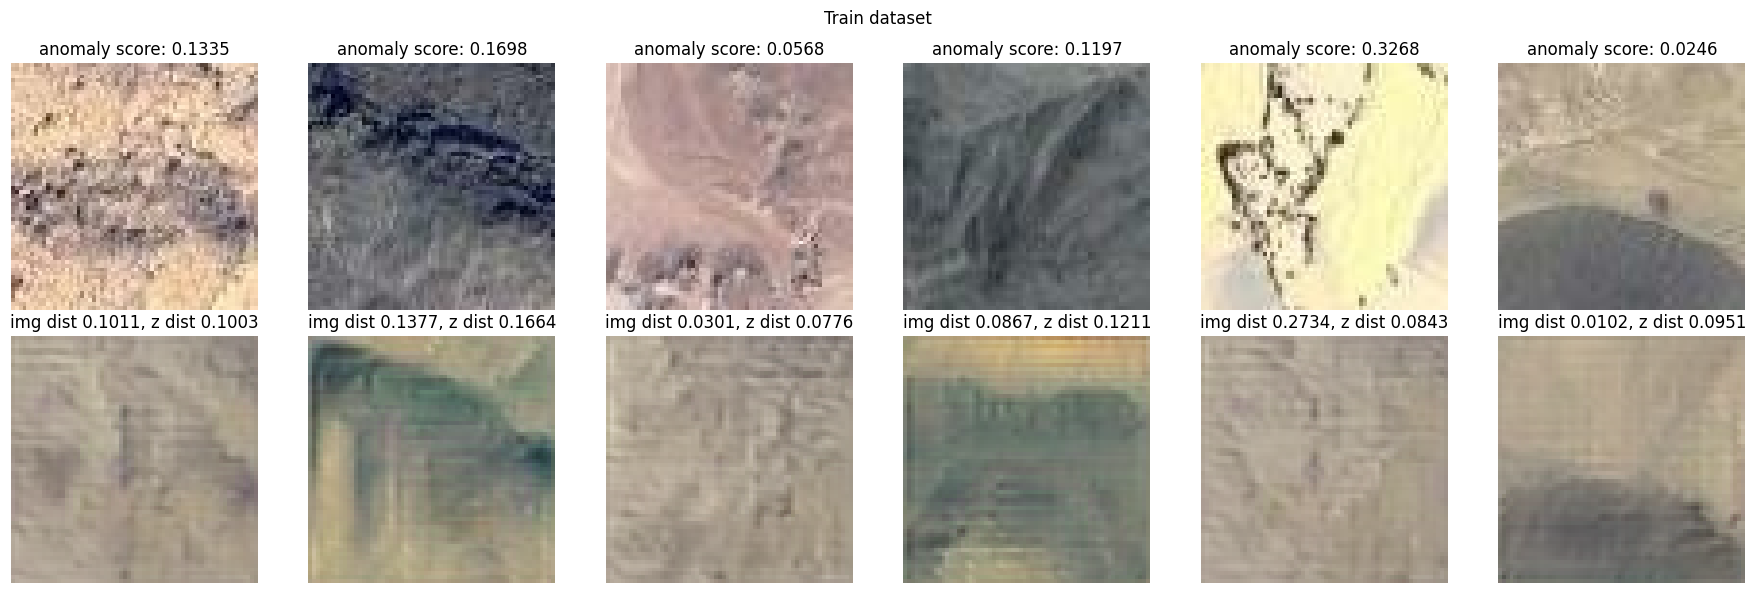

In [20]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[j + 12]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

## Anomalies dataset

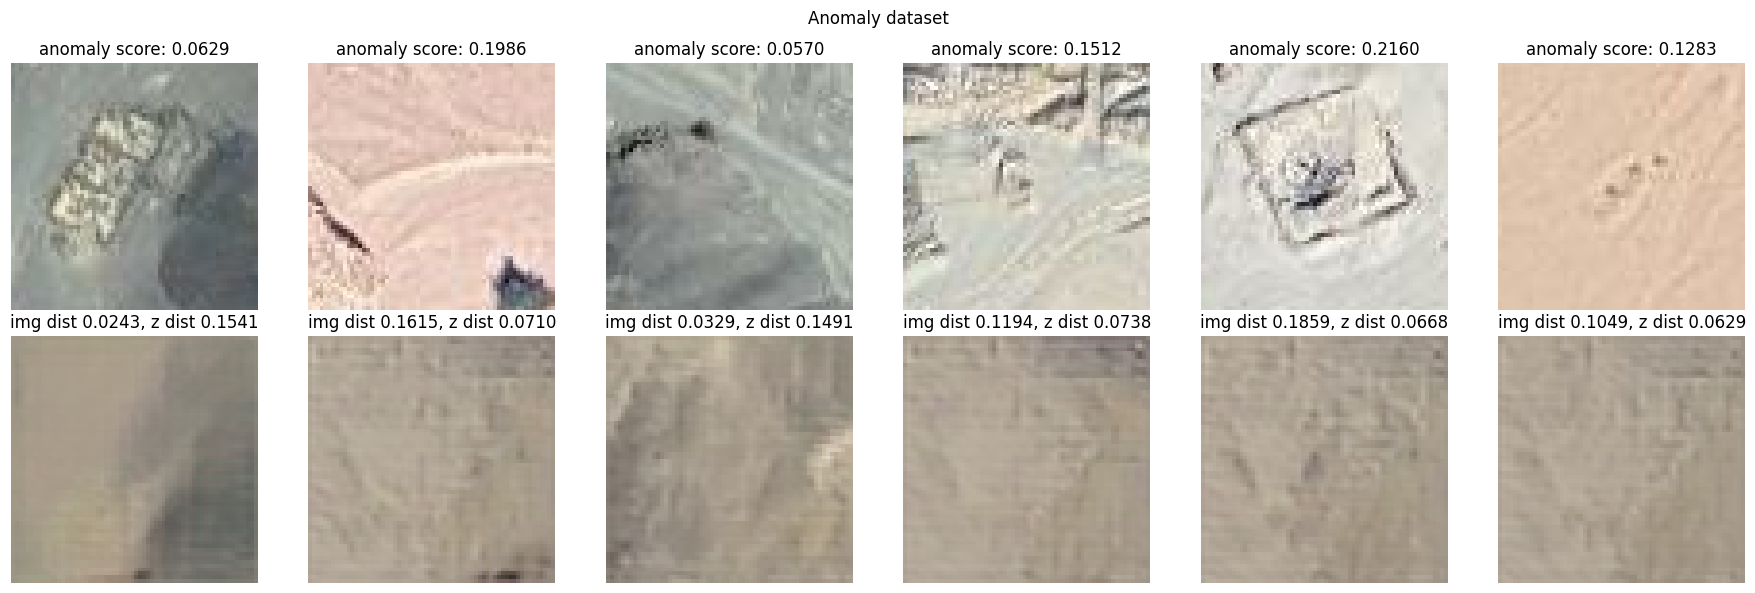

In [21]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomaly dataset')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = anomalies_dataset[j]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

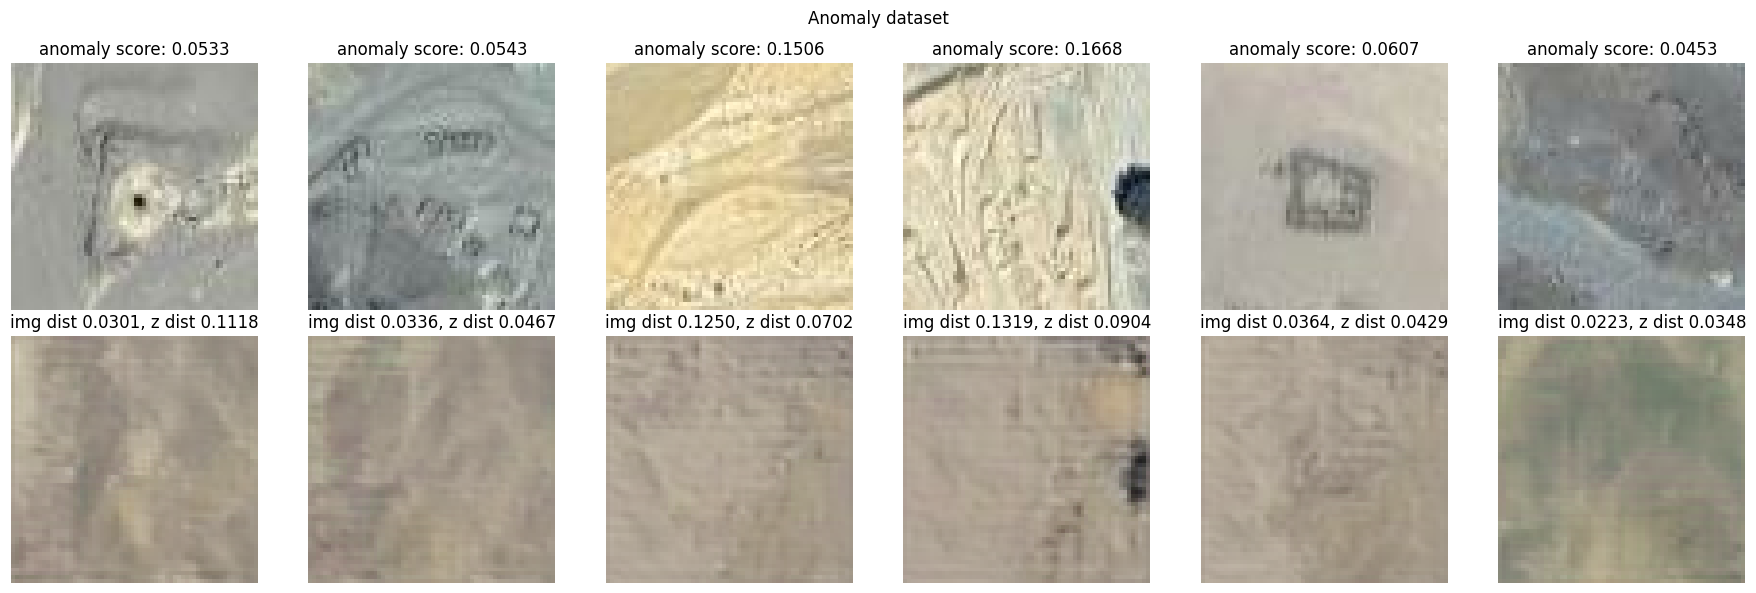

In [22]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomaly dataset')

for j in range(ncols):
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = anomalies_dataset[j + 6]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].cpu().permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

# Самые аномальные картинки

## Anomalies dataset

In [23]:
anomaly_scores = {}

for i in tqdm(range(len(anomalies_dataset))):
    img, label = anomalies_dataset[i]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)
    anomaly_scores[i] = anomaly_score
    
anomaly_scores_sorted = sorted([(score, i) for (i, score) in anomaly_scores.items()])

100%|██████████| 163/163 [00:02<00:00, 57.46it/s]


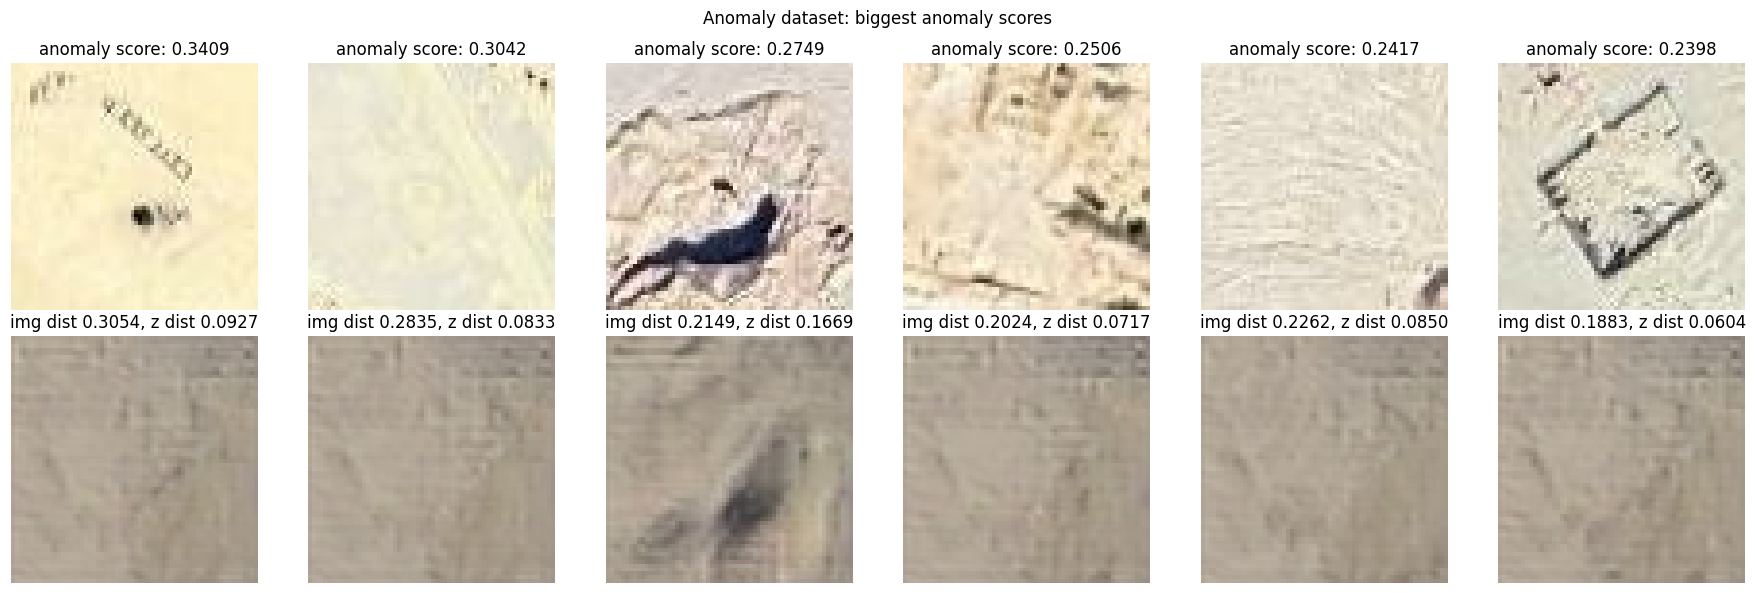

In [24]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomaly dataset: biggest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_sorted[len(anomaly_scores_sorted) - 1 - j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = anomalies_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

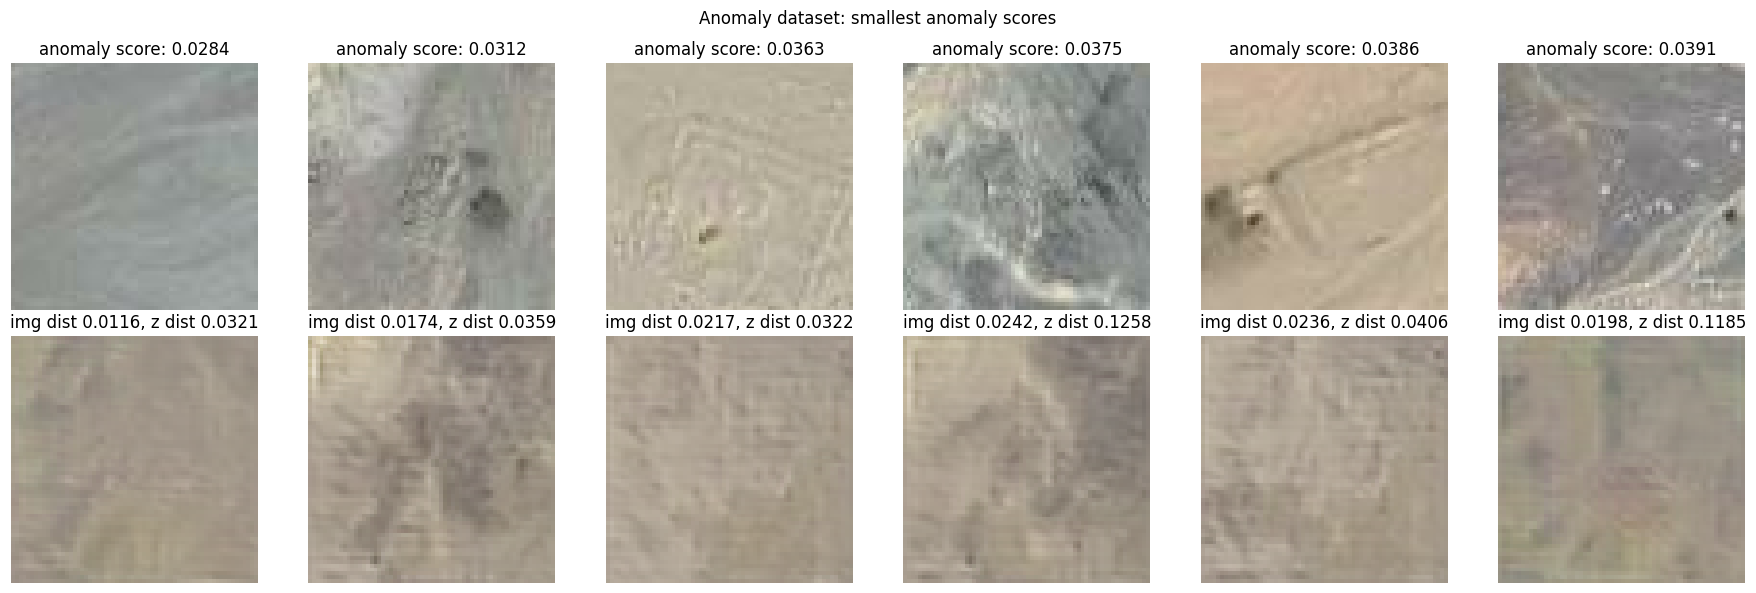

In [25]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Anomaly dataset: smallest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_sorted[j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = anomalies_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

fig.savefig('least_suspicious')

## Train dataset

In [26]:
anomaly_scores_train = {}

for i in tqdm(range(len(train_dataset))):
    img, label = train_dataset[i]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)
    anomaly_scores_train[i] = anomaly_score

100%|██████████| 139945/139945 [34:46<00:00, 67.07it/s] 


In [27]:
anomaly_scores_train_sorted = sorted([(score, i) for (i, score) in anomaly_scores_train.items()])

In [28]:
anomaly_scores_lst = [score for (score, i) in anomaly_scores_sorted]
anomaly_scores_train_lst = [score for (score, i) in anomaly_scores_train_sorted]

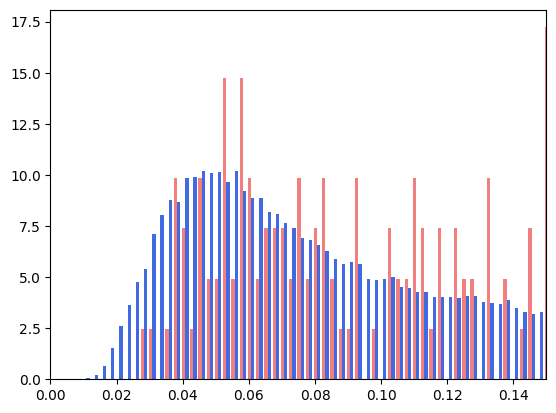

In [29]:
plt.hist([anomaly_scores_lst, anomaly_scores_train_lst], bins=400, color=['lightcoral', 'royalblue'], density=True);
plt.xlim([0, 0.15]);
# plt.hist(anomaly_scores_train_lst, bins=100, color='royalblue');
plt.savefig('hist');

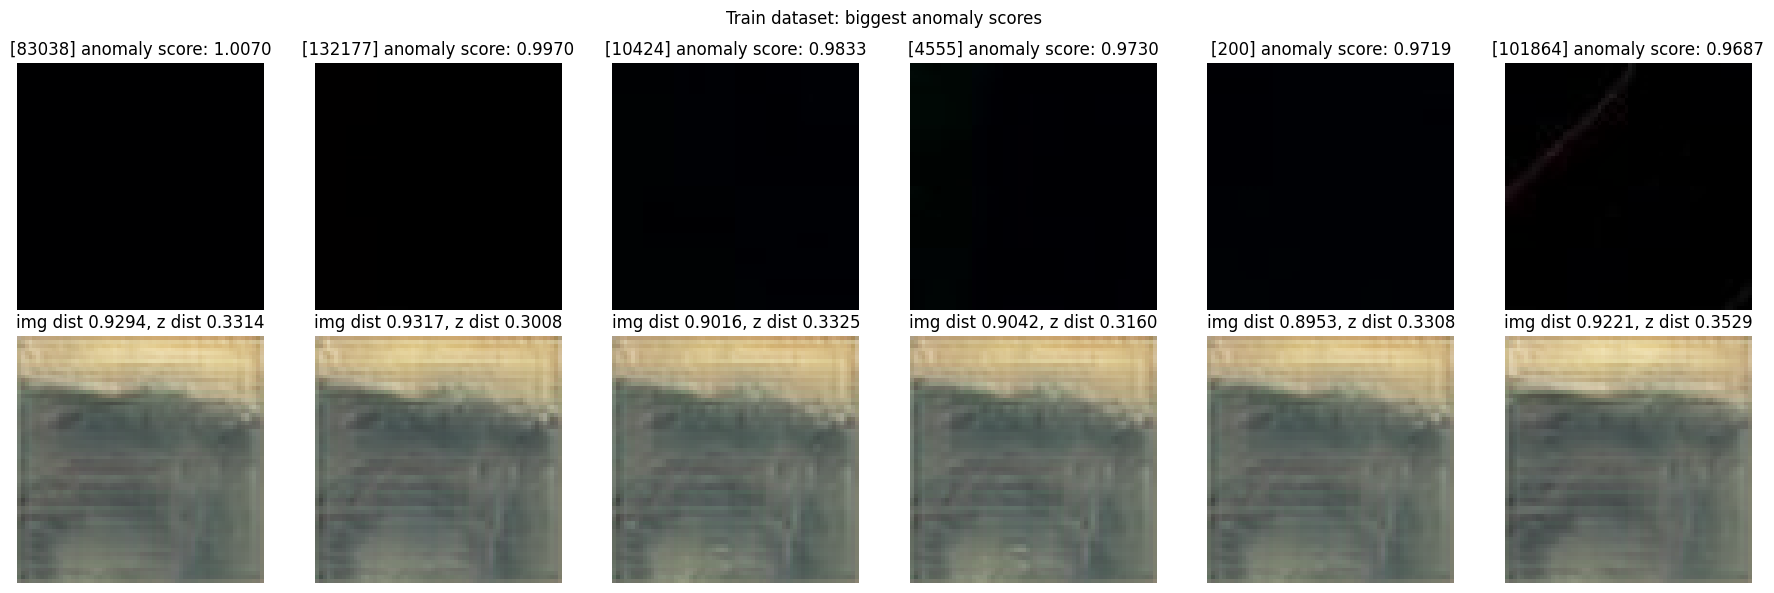

In [30]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: biggest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_train_sorted[len(anomaly_scores_train_sorted) - 1 - j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'[{ind_in_dataset}] anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

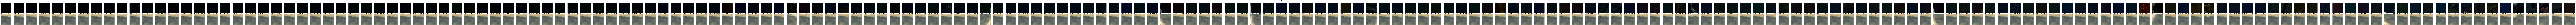

In [31]:
nrows, ncols = 2, 200

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: biggest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_train_sorted[len(anomaly_scores_train_sorted) - 1 - j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'[{ind_in_dataset}] anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

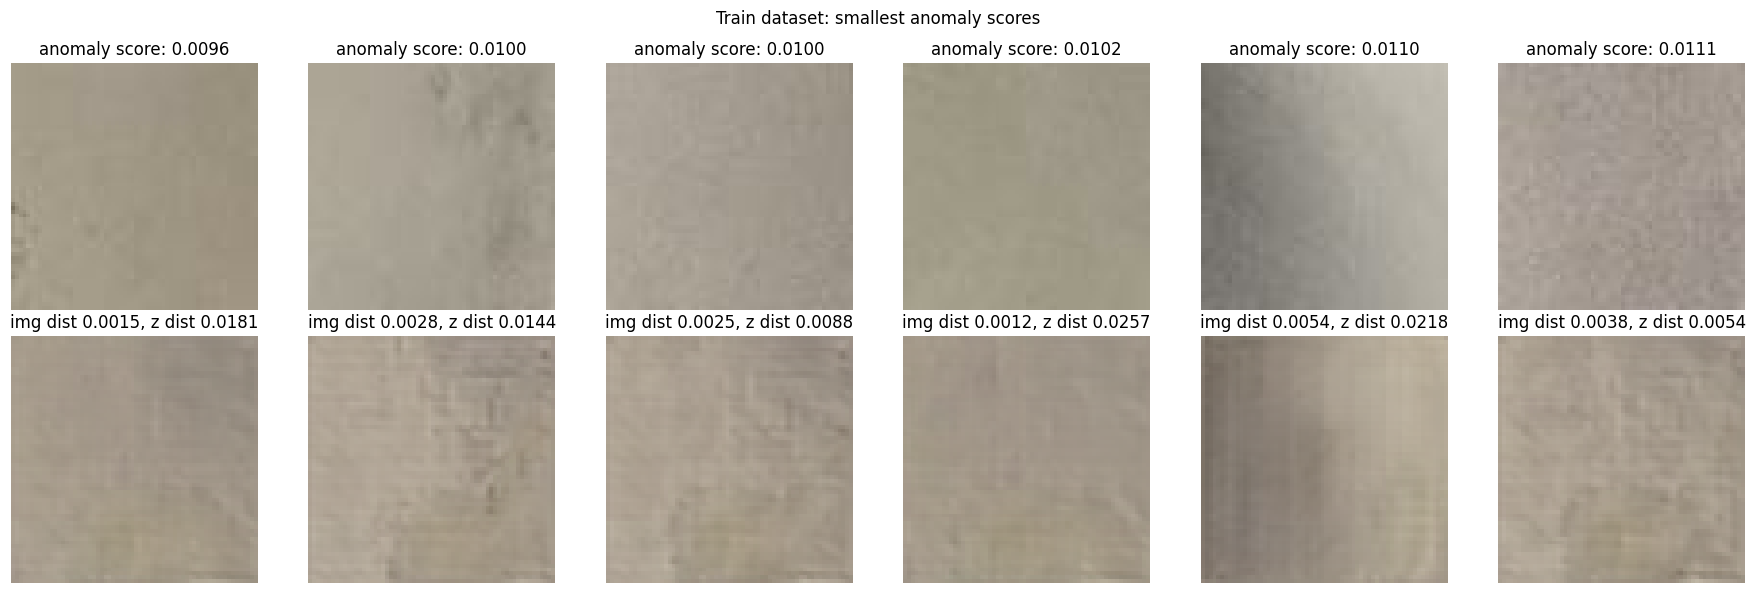

In [33]:
nrows, ncols = 2, 6

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: smallest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_train_sorted[j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()

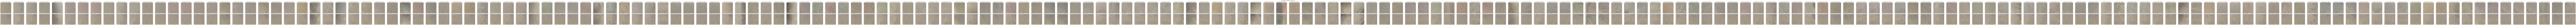

In [34]:
nrows, ncols = 2, 200

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (3 * ncols, 3 * nrows))

fig.suptitle('Train dataset: smallest anomaly scores')

for j in range(ncols):
    
    ind_in_dataset = anomaly_scores_train_sorted[j][1]
    
    for i in range(nrows):
        axs[i, j].axis('off')
        axs[i, j].grid('off')
        
    img, label = train_dataset[ind_in_dataset]
    img = img[None, :, :, :]
    fake_img, img_distance, anomaly_score, z_distance = test(img)

    axs[0, j].imshow((img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    axs[1, j].imshow((fake_img[0].permute(1, 2, 0).detach().numpy() + 1) / 2)
    
    axs[0, j].title.set_text(f'anomaly score: {anomaly_score:.4f}')
    axs[1, j].title.set_text(f'img dist {img_distance:.4f}, z dist {z_distance:.4f}')
    
fig.tight_layout()
fig.show()